In [ ]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import torch
import torch.nn as nn
import numpy as np
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
# from tqdm import tqdm
!pip install pytorch_lightning
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import seaborn as sns
!pip install torchsummary
from torchsummary import summary
!pip install wandb
import wandb
api_key = '4255b25e16e2daac5513ba068e73e46cbb68b63f'
wandb.login(key=api_key)
wandb.init(project="Conditional GAN", entity = "M23MAC004")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_value = 19
torch.manual_seed(seed_value)
print('Done')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Extract data
with zipfile.ZipFile("/content/drive/MyDrive/Assignment/Archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
# Loading dataset
path = Path('/content/')
df = pd.read_csv('/content/meta/esc50.csv')
df

Mounted at /content/drive


NameError: name 'zipfile' is not defined

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in (range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size= 80 ,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size= 80,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        # examples = torch.cat(examples)
        examples = torch.stack(examples)
        examples = torch.squeeze(examples)
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]

# Data Setup
test_samp = 1 ## Do not change this!!
valid_samp = 5 # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
batch_size = 40 # Free to change
num_workers = 2 # Free to change


custom_data_module = CustomDataModule(batch_size=batch_size,
                                      num_workers=num_workers,
                                      data_directory=path,
                                      data_frame=df,
                                      validation_fold=valid_samp,
                                      testing_fold=test_samp,  # set to 0 for no test set
                                      esc_10_flag=True,
                                      file_column='filename',
                                      label_column='category',
                                      sampling_rate=44100,
                                      new_sampling_rate=16000,  # new sample rate for input
                                      sample_length_seconds=1  # new length of input in seconds
                                      )

custom_data_module.setup()

def kfold(k):
    test_samp = 1
    valid_samp = k
    batch_size = 40
    num_workers = 2
    custom_data_module = CustomDataModule(batch_size=batch_size,
                                        num_workers=num_workers,
                                        data_directory=path,
                                        data_frame=df,
                                        validation_fold=valid_samp,
                                        testing_fold=test_samp,
                                        esc_10_flag=True,
                                        file_column='filename',
                                        label_column='category',
                                        sampling_rate=44100,
                                        new_sampling_rate=16000,
                                        sample_length_seconds=1)
    custom_data_module.setup()
    return custom_data_module

In [ ]:
class ModelTrainer:
    def __init__(self, model, optimizer, loss_function, epochs, batch_size, model_name):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.epochs = epochs
        self.batch_size = batch_size
        self.model_name = model_name

    def train(self, custom_data_module):
        wandb.init(project='DL_Assignment_2', name=self.model_name)

        train_loss_list = []
        train_accuracy_list = []
        validation_loss_list = []
        validation_accuracy_list = []

        for epoch in range(self.epochs):

            train_loss_fold =[]
            train_accuracy_fold = []
            validation_loss_fold = []
            validation_accuracy_fold = []

            for k in range(2,6):

                data_module = kfold(k)
                train_loader = data_module.train_dataloader()
                val_loader = data_module.val_dataloader()

                batch_train_loss = 0
                batch_train_accuracy = 0

                # Training loop
                self.model.train()
                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                    self.optimizer.zero_grad()
                    y_pred = self.model(X_batch)
                    loss = self.loss_function(y_pred, y_batch)
                    loss.backward()
                    self.optimizer.step()
                    batch_train_loss += loss.item()
                    accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y_batch).item()
                    batch_train_accuracy += accuracy

                train_loss_fold.append(batch_train_loss)
                train_accuracy_fold.append((batch_train_accuracy / 240))

                # Validation loop
                batch_validation_loss = 0
                batch_validation_accuracy = 0
                self.model.eval()
                with torch.no_grad():
                    for X_batch, y_batch in val_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                        y_pred = self.model(X_batch)
                        loss = self.loss_function(y_pred, y_batch)
                        accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y_batch).item()
                        batch_validation_loss += loss.item()
                        batch_validation_accuracy += accuracy

                validation_loss_fold.append(batch_validation_loss)
                validation_accuracy_fold.append((batch_validation_accuracy/80))

            #Avg loss and accuracy of 4 fold in a epoch
            avg_train_loss = np.mean(train_loss_fold)
            avg_train_accuracy = np.mean(train_accuracy_fold)
            avg_validation_loss = np.mean(validation_loss_fold)
            avg_validation_accuracy = np.mean(validation_accuracy_fold)

            # Append values to the lists
            train_loss_list.append(avg_train_loss)
            train_accuracy_list.append(avg_train_accuracy)
            validation_loss_list.append(avg_validation_loss)
            validation_accuracy_list.append(avg_validation_accuracy)

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "train_accuracy": avg_train_accuracy * 100,
                "validation_loss": avg_validation_loss,
                "validation_accuracy": avg_validation_accuracy * 100
            })

            print(f'Epoch:{epoch + 1}\n'
                  f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy * 100:.2f}%\n'
                  f'Validation Loss: {avg_validation_loss:.4f}, Validation Accuracy: {avg_validation_accuracy * 100:.2f}%')

        return train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list
    # Plot of loss and accuarcy on traina and validation dataset
    def plot_loss_accuracy(self, epochs, metric_values_list, labels, ylabel, title, colors):
        for metric_values, label, color in zip(metric_values_list, labels, colors):
            plt.plot(range(1, epochs + 1), metric_values, label=label, color=color)
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()

    def evaluation_and_metrics(self, custom_data_module):
        self.model.eval()
        with torch.no_grad():
            test_loader = custom_data_module.test_dataloader()

            avg_test_loss = 0
            avg_test_accuracy = 0
            Y_pred = torch.tensor([])
            y_test = torch.tensor([])
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = self.model(X_batch)
                loss = self.loss_function(y_pred, y_batch)
                accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y_batch).item()
                avg_test_loss += loss.item()
                avg_test_accuracy += accuracy
                Y_pred = Y_pred.to(device)
                Y_pred = torch.cat((Y_pred, y_pred), dim=0)
                y_test = torch.cat((y_test, y_batch.to(y_test.device)), dim=0)

            avg_test_accuracy = avg_test_accuracy / 80

            wandb.log({"Test Loss": f"{avg_test_loss:.4f}"})
            wandb.log({"Test Accuracy": f"{(avg_test_accuracy * 100):.2f}"})

            print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy * 100:.2f}%')



            # Calculate F1 score without specifying average
            f1 = f1_score(y_test.cpu(),torch.argmax(Y_pred.cpu(), dim = 1), average='weighted')
            print(f"F1 SCORE: {f1:.4f}")
            wandb.log({"Overall F1 Score": f"{f1}"})

            # Plot confusion matrix
            conf_matrix = confusion_matrix(y_test.cpu(), torch.argmax(Y_pred.cpu(), dim=1))
            plt.figure(figsize=(10, 8))
            class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()

            # Plot ROC curves
            y_test_onehot = torch.zeros(len(y_test), len(class_names), device = Y_pred.device)
            y_test_indices = y_test.unsqueeze(1).to(torch.long).to(Y_pred.device)
            y_test_onehot.scatter_(1, y_test_indices, 1)


            fpr = dict()
            tpr = dict()
            roc_auc = dict()

            for i in range(len(class_names)):
                fpr[i], tpr[i], _ = roc_curve(y_test_onehot.cpu().numpy()[:, i], torch.argmax(Y_pred.cpu(), dim=1) == i)
                roc_auc[i] = auc(fpr[i], tpr[i])

            plt.figure(figsize=(12, 8))
            for i in range(len(class_names)):
                plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

            plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=9, out_channels=26, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(26),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=26, out_channels=52, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(52),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=52, out_channels=104, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(104),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=104, out_channels=26, kernel_size=2, stride = 2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(26),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=26, out_channels=20, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Flatten()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(880, 512),
            nn.Sigmoid(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch:1
Training Loss: 13.2362, Training Accuracy: 20.21%
Validation Loss: 2.3197, Validation Accuracy: 10.00%
Epoch:2
Training Loss: 11.8969, Training Accuracy: 29.90%
Validation Loss: 2.3283, Validation Accuracy: 11.25%
Epoch:3
Training Loss: 11.0905, Training Accuracy: 36.88%
Validation Loss: 2.0362, Validation Accuracy: 20.94%
Epoch:4
Training Loss: 10.5057, Training Accuracy: 42.71%
Validation Loss: 1.8423, Validation Accuracy: 34.69%
Epoch:5
Training Loss: 9.9477, Training Accuracy: 46.88%
Validation Loss: 1.7288, Validation Accuracy: 40.31%
Epoch:6
Training Loss: 9.3929, Training Accuracy: 49.90%
Validation Loss: 1.6541, Validation Accuracy: 39.69%
Epoch:7
Training Loss: 8.9750, Training Accuracy: 50.21%
Validation Loss: 1.5892, Validation Accuracy: 41.88%
Epoch:8
Training Loss: 8.6683, Training Accuracy: 52.19%
Validation Loss: 1.5345, Validation Accuracy: 43.75%
Epoch:9
Training Loss: 8.4333, Training Accuracy: 51.67%
Validation Loss: 1.4888, Validation Accuracy: 43.44%
Epoch:

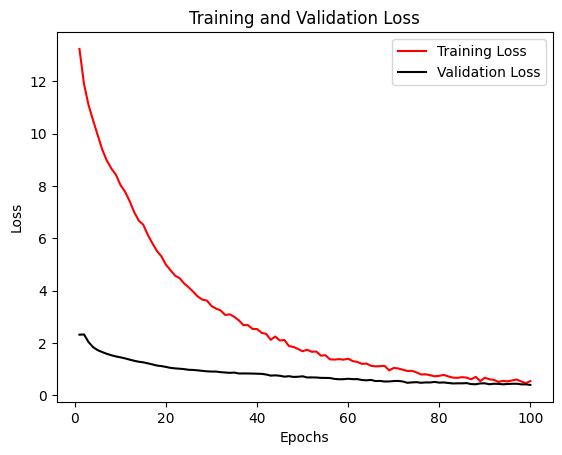

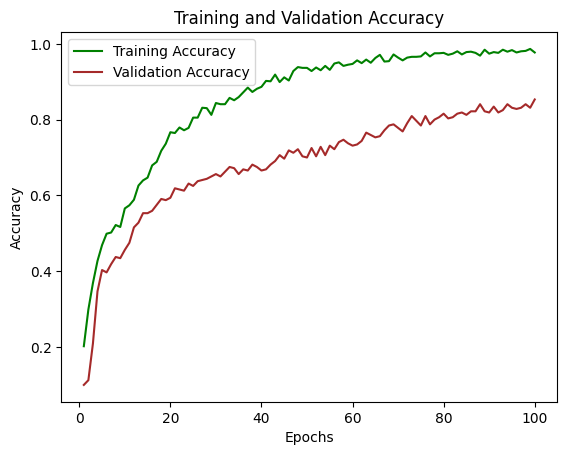

Test Loss: 2.4624, Test Accuracy: 47.50%
F1 SCORE: 0.4066


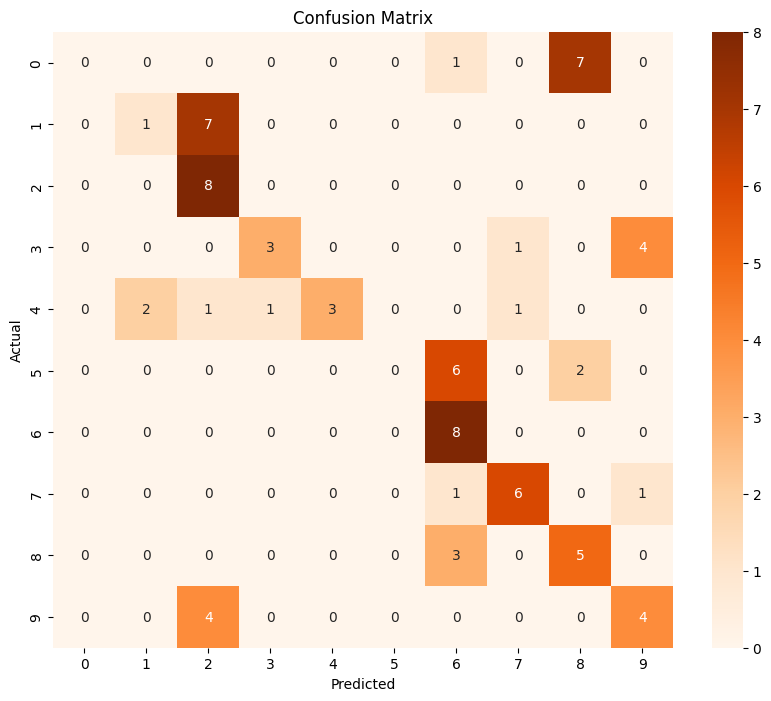

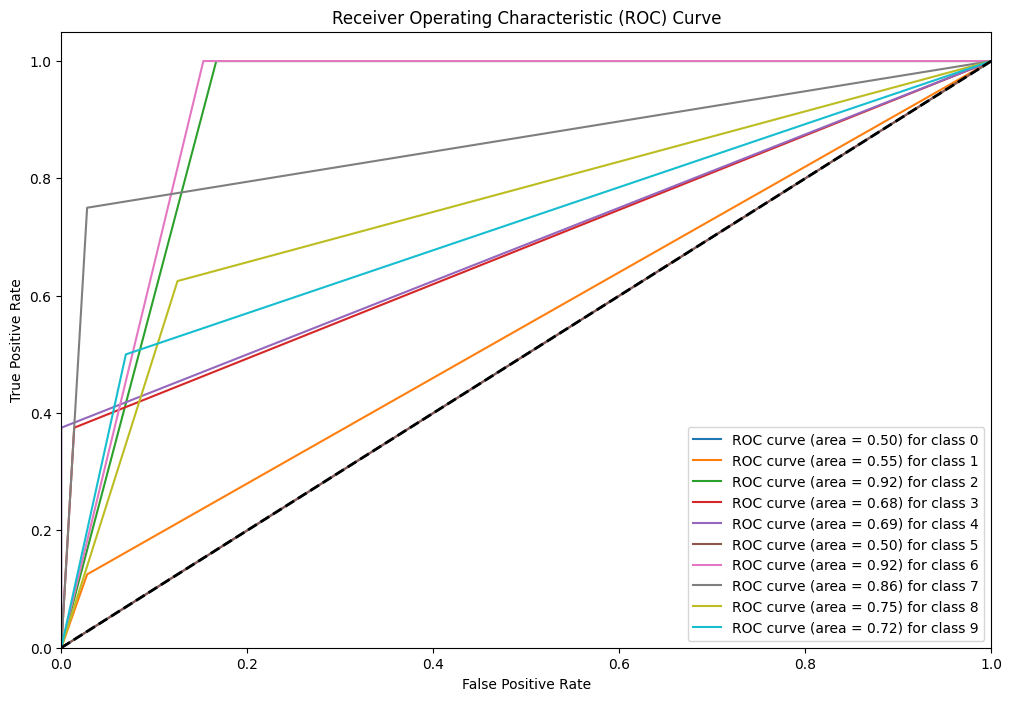

Total_parameters: 484316
Trainable_parameters: 484316
Non_Trainable_parameters: 0


In [ ]:

# Instantiate your model, optimizer, and loss function
epochs = 100
cnn_classifier = CnnModel()

trainer = ModelTrainer(model=cnn_classifier,
                     optimizer=torch.optim.Adam(cnn_classifier.parameters(), lr=0.0001),
                     loss_function=nn.CrossEntropyLoss(),
                     epochs = epochs,
                     batch_size= 40,
                     model_name = 'cnn')

# Train the model using k-fold cross-validation with batch training
train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = trainer.train(custom_data_module)
# Plot loss
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_loss_list, validation_loss_list],
                     labels = ['Training Loss', 'Validation Loss'], ylabel = 'Loss',
                     title = 'Training and Validation Loss', colors=['red', 'black'])
# Plot accuracy
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_accuracy_list, validation_accuracy_list],
                     labels = ['Training Accuracy', 'Validation Accuracy'], ylabel = 'Accuracy',
                     title = 'Training and Validation Accuracy', colors=['green', 'brown'])
# # Evaluate and plot confusion matrix
trainer.evaluation_and_metrics(custom_data_module)

Total_parameters = sum(p.numel() for p in cnn_classifier.parameters())
Trainable_parameters = sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad)
Non_Trainable_parameters = Total_parameters - Trainable_parameters
print('Total_parameters:',Total_parameters )
print('Trainable_parameters:',Trainable_parameters)
print('Non_Trainable_parameters:',Non_Trainable_parameters )

In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=9, out_channels=26, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(26),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=26, out_channels=52, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(52),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=52, out_channels=104, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(104),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=104, out_channels=26, kernel_size=2, stride = 2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(26),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv1d(in_channels=26, out_channels=20, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten())

    def forward(self, x):
        x = self.conv_layers(x)
        return x


class Positionencoder(nn.Module):
    def __init__(self, max_len=880):
        super(Positionencoder, self).__init__()
        self.max_len = max_len
        self.encoding = None

    def generate_encoding(self, pos):
        position = torch.arange(0, pos).unsqueeze(1)
        p = position / (10000 ** (torch.arange(0, self.max_len).view(-1, 2)[:, 0].repeat_interleave(2) / self.max_len))
        encoding = torch.zeros(pos, self.max_len)
        encoding[::2, :] = (encoding[::2, :] + torch.sin(p[::2, :]))
        encoding[1::2, :] = (encoding[1::2, :] + torch.cos(p[1::2, :]))
        return encoding

    def forward(self, x):
        pos = x.shape[0]
        if self.encoding is None or self.encoding.size(0) != pos:
            self.encoding = self.generate_encoding(pos)
        self.encoding = self.encoding.to(x.device)

        return x + self.encoding[:, :x.size(1)].detach()


class Selfattention(nn.Module):
    def __init__(self, d_model, num_heads,dropout):
        super(Selfattention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        Q = self.WQ(query).view(query.size(0), -1, self.num_heads, self.head_dim)
        K = self.WK(key).view(key.size(0), -1, self.num_heads, self.head_dim)
        V = self.WV(value).view(value.size(0), -1, self.num_heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", Q, K)
        attention = torch.softmax(energy / (self.head_dim ** 0.5), dim=3)
        x = torch.einsum("nhql,nlhd->nqhd", attention, V).contiguous()
        x = x.view(x.size(0), -1, self.d_model)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.attention_blocks = nn.ModuleList([
            Selfattention(d_model, num_heads, dropout) for _ in range(num_layers)
        ])
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for attention_block in self.attention_blocks:
            residual = x.clone()
            x = self.norm1(x)
            x = attention_block(x, x, x)
            x = self.dropout(x)
            x = x + residual
            x = self.norm2(x)
        return x


class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

class CnnTransformerModel(nn.Module):
    def __init__(self, input_channels, output_channels, d_model, num_heads, num_layers, num_classes,dropout):
        super(CnnTransformerModel, self).__init__()
        self.base_network = CnnModel()
        self.positional_encoding = Positionencoder()
        self.transformer_encoder = TransformerEncoder(d_model, num_heads, num_layers,dropout)
        self.mlp_head = MLPHead(d_model, num_classes)

    def forward(self, x):
        x = self.base_network(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        cls_token = x[:, 0, :]
        output = self.mlp_head(cls_token)
        return output

Articture_2
tranformer_1_head


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇███████████████████
train_loss,█▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▂▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
validation_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Overall F1 Score,0.4066427581133463
Test Accuracy,47.50
Test Loss,2.4624
epoch,100
train_accuracy,97.70833
train_loss,0.54472


Epoch:1
Training Loss: 13.5595, Training Accuracy: 16.35%
Validation Loss: 2.3611, Validation Accuracy: 10.00%
Epoch:2
Training Loss: 12.3208, Training Accuracy: 23.23%
Validation Loss: 2.3054, Validation Accuracy: 14.37%
Epoch:3
Training Loss: 11.6918, Training Accuracy: 27.40%
Validation Loss: 1.9895, Validation Accuracy: 29.06%
Epoch:4
Training Loss: 11.0922, Training Accuracy: 35.21%
Validation Loss: 1.8311, Validation Accuracy: 34.06%
Epoch:5
Training Loss: 10.4773, Training Accuracy: 39.58%
Validation Loss: 1.7497, Validation Accuracy: 40.62%
Epoch:6
Training Loss: 9.9396, Training Accuracy: 47.40%
Validation Loss: 1.6670, Validation Accuracy: 44.06%
Epoch:7
Training Loss: 9.3314, Training Accuracy: 52.08%
Validation Loss: 1.6095, Validation Accuracy: 45.63%
Epoch:8
Training Loss: 8.9042, Training Accuracy: 58.33%
Validation Loss: 1.5722, Validation Accuracy: 44.69%
Epoch:9
Training Loss: 8.5748, Training Accuracy: 61.77%
Validation Loss: 1.5087, Validation Accuracy: 52.50%
Epoch

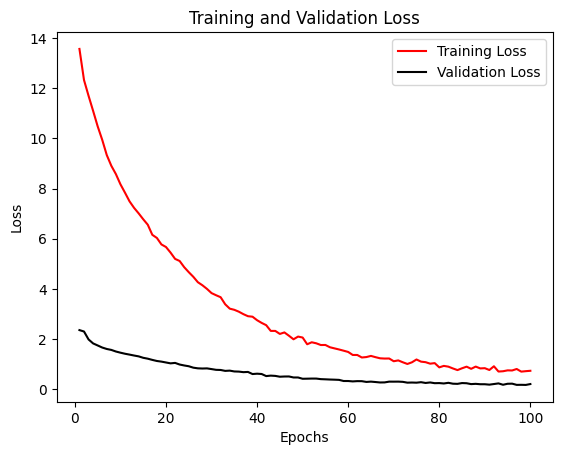

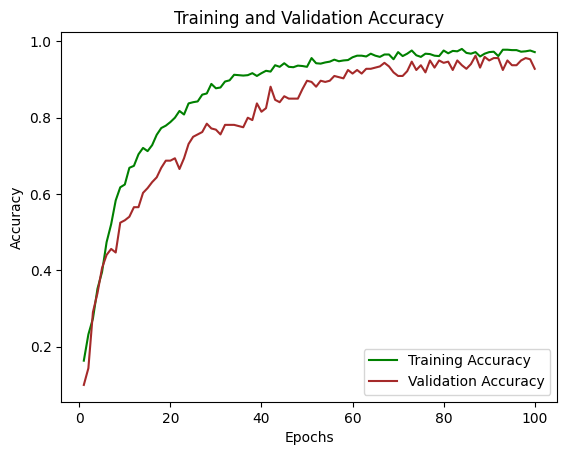

Test Loss: 1.6462, Test Accuracy: 55.00%
F1 SCORE: 0.5187


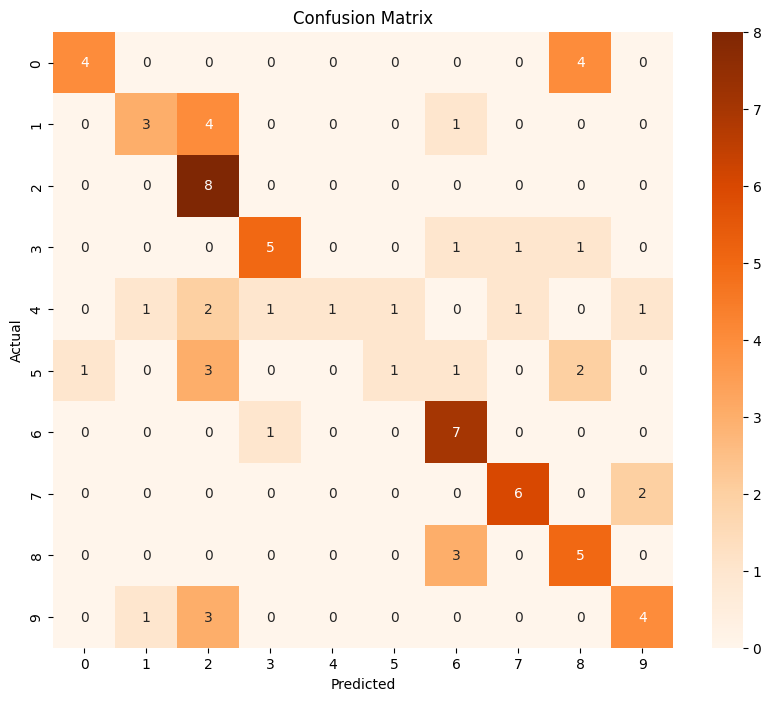

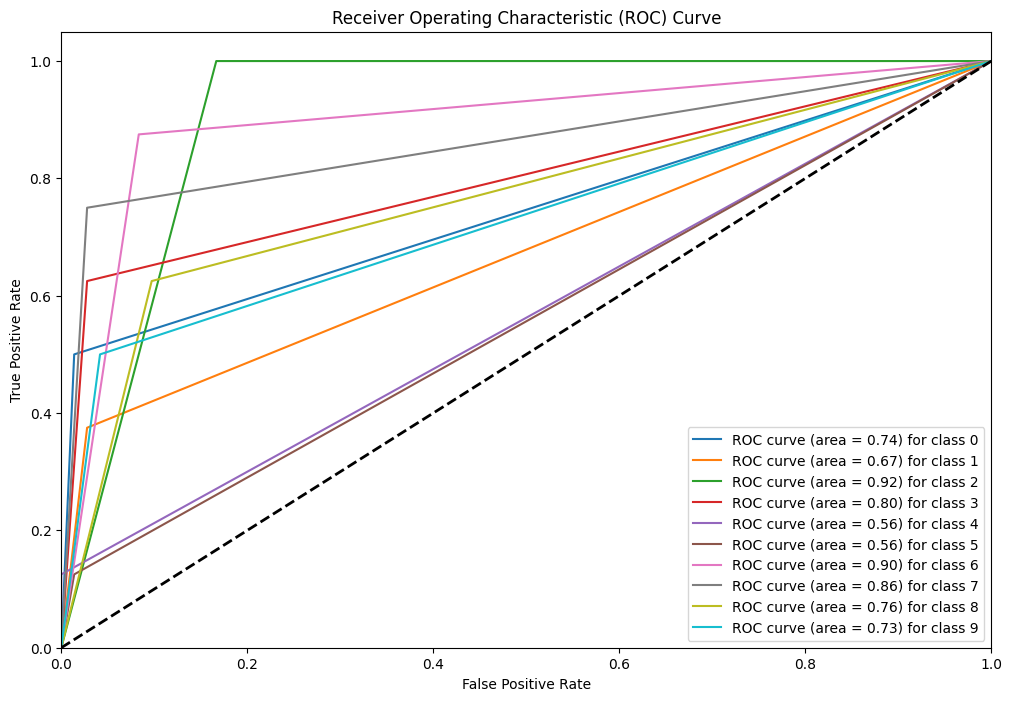

Total_parameters: 6322984
Trainable_parameters: 6322984
Non_Trainable_parameters: 0


In [ ]:
# Instantiate your model, optimizer, and loss function
print('Articture_2')
print('tranformer_1_head')
epochs = 100
tranformer_1_head = CnnTransformerModel(input_channels = 9 , output_channels = 20,d_model= 880, num_heads=1, num_layers=2, num_classes=10,dropout=0.1)
trainer = ModelTrainer(model=tranformer_1_head,
                     optimizer=torch.optim.Adam(tranformer_1_head.parameters(), lr=0.0001),
                     loss_function=nn.CrossEntropyLoss(),
                     epochs = epochs,
                     batch_size= 40,
                     model_name = 'tranformer_1_head')

# Train the model using k-fold cross-validation with batch training
train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = trainer.train(custom_data_module)
# Plot loss
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_loss_list, validation_loss_list],
                     labels = ['Training Loss', 'Validation Loss'], ylabel = 'Loss',
                     title = 'Training and Validation Loss', colors=['red', 'black'])
# Plot accuracy
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_accuracy_list, validation_accuracy_list],
                     labels = ['Training Accuracy', 'Validation Accuracy'], ylabel = 'Accuracy',
                     title = 'Training and Validation Accuracy', colors=['green', 'brown'])
# # Evaluate and plot confusion matrix
trainer.evaluation_and_metrics(custom_data_module)
Total_parameters = sum(p.numel() for p in tranformer_1_head.parameters())
Trainable_parameters = sum(p.numel() for p in tranformer_1_head.parameters() if p.requires_grad)
Non_Trainable_parameters = Total_parameters - Trainable_parameters
print('Total_parameters:',Total_parameters )
print('Trainable_parameters:',Trainable_parameters)
print('Non_Trainable_parameters:',Non_Trainable_parameters )

Articture_2
tranformer_2_head


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████████████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇██████████████████
validation_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Overall F1 Score,0.5187240537240537
Test Accuracy,55.00
Test Loss,1.6462
epoch,100
train_accuracy,97.1875
train_loss,0.74095


Epoch:1
Training Loss: 12.3144, Training Accuracy: 20.52%
Validation Loss: 2.6351, Validation Accuracy: 9.69%
Epoch:2
Training Loss: 10.1244, Training Accuracy: 40.62%
Validation Loss: 2.6894, Validation Accuracy: 12.81%
Epoch:3
Training Loss: 8.4133, Training Accuracy: 54.27%
Validation Loss: 1.8460, Validation Accuracy: 31.25%
Epoch:4
Training Loss: 6.9881, Training Accuracy: 63.85%
Validation Loss: 1.3255, Validation Accuracy: 53.12%
Epoch:5
Training Loss: 6.0549, Training Accuracy: 69.27%
Validation Loss: 1.0979, Validation Accuracy: 60.94%
Epoch:6
Training Loss: 5.2970, Training Accuracy: 72.40%
Validation Loss: 0.9767, Validation Accuracy: 66.25%
Epoch:7
Training Loss: 4.5978, Training Accuracy: 76.88%
Validation Loss: 0.9447, Validation Accuracy: 63.75%
Epoch:8
Training Loss: 4.3590, Training Accuracy: 76.98%
Validation Loss: 0.7689, Validation Accuracy: 73.75%
Epoch:9
Training Loss: 3.7015, Training Accuracy: 80.94%
Validation Loss: 0.7231, Validation Accuracy: 75.00%
Epoch:10


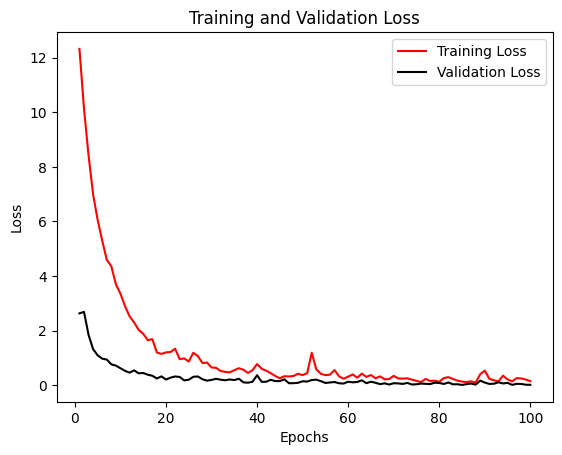

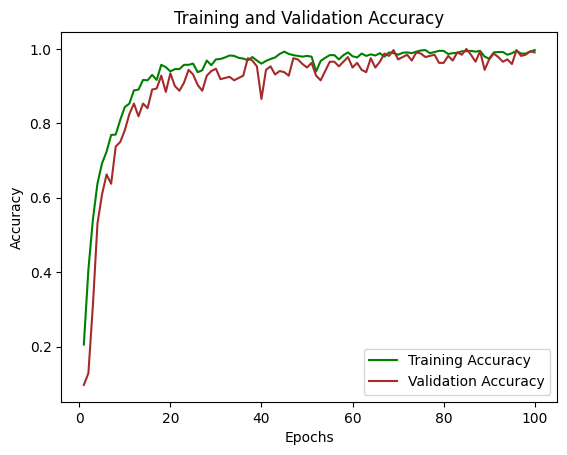

Test Loss: 2.8367, Test Accuracy: 47.50%
F1 SCORE: 0.4371


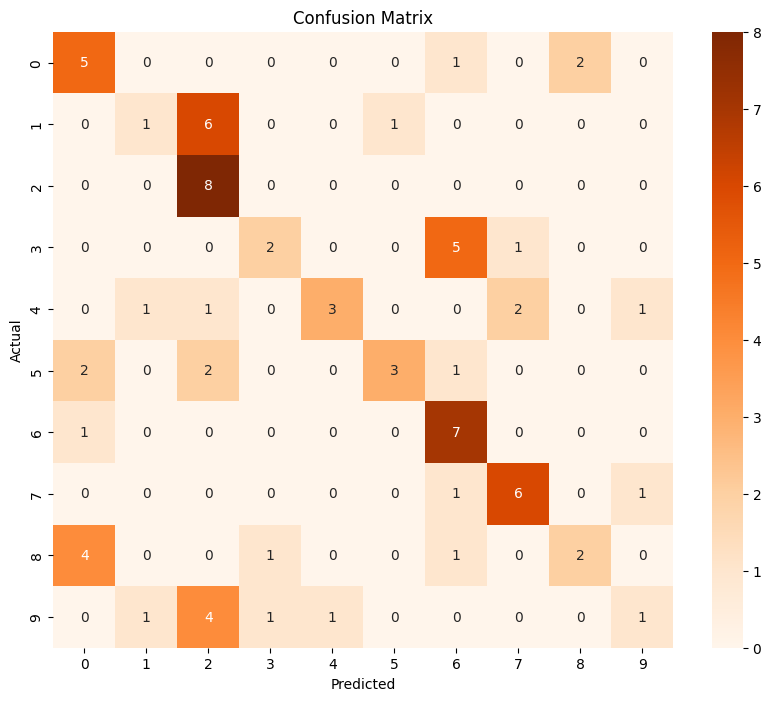

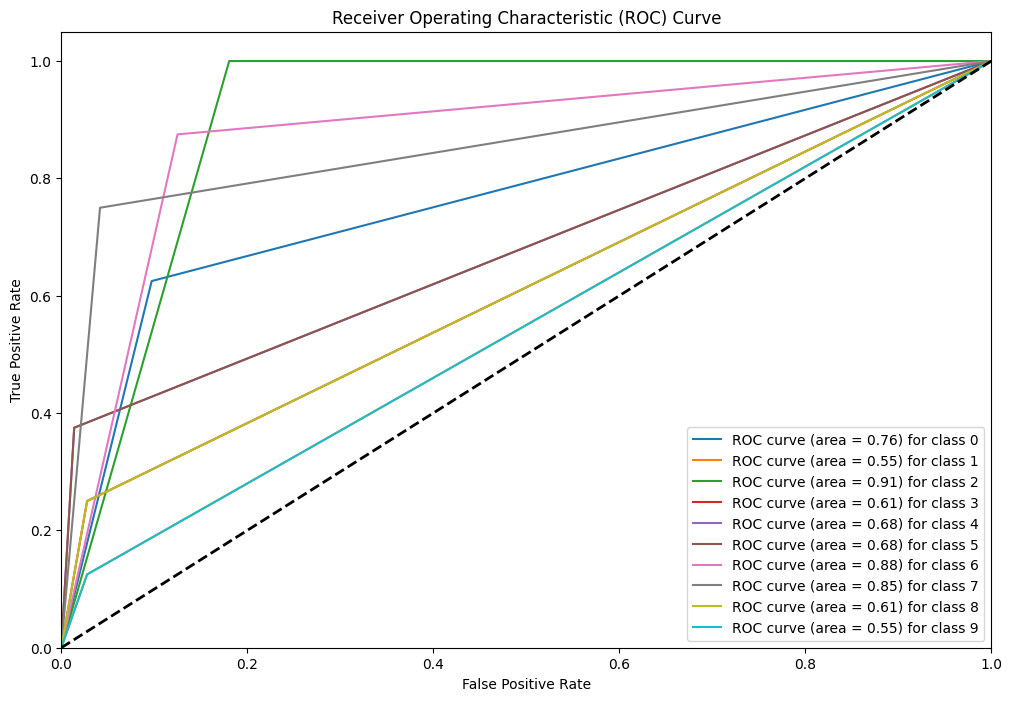

Total_parameters: 6322984
Trainable_parameters: 6322984
Non_Trainable_parameters: 0


In [ ]:
# Instantiate your model, optimizer, and loss function
print('Articture_2')
print('tranformer_2_head')
epochs = 100
tranformer_2_head = CnnTransformerModel(input_channels = 9 , output_channels = 20,d_model= 880, num_heads=2, num_layers=2, num_classes=10,dropout=0.2)
trainer = ModelTrainer(model=tranformer_2_head,
                     optimizer=torch.optim.Adam(tranformer_2_head.parameters(), lr=0.001),
                     loss_function=nn.CrossEntropyLoss(),
                     epochs = epochs,
                     batch_size= 40,
                     model_name = 'tranformer_2_head')

# Train the model using k-fold cross-validation with batch training
train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = trainer.train(custom_data_module)
# Plot loss
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_loss_list, validation_loss_list],
                     labels = ['Training Loss', 'Validation Loss'], ylabel = 'Loss',
                     title = 'Training and Validation Loss', colors=['red', 'black'])
# Plot accuracy
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_accuracy_list, validation_accuracy_list],
                     labels = ['Training Accuracy', 'Validation Accuracy'], ylabel = 'Accuracy',
                     title = 'Training and Validation Accuracy', colors=['green', 'brown'])
# # Evaluate and plot confusion matrix
trainer.evaluation_and_metrics(custom_data_module)
Total_parameters = sum(p.numel() for p in tranformer_2_head.parameters())
Trainable_parameters = sum(p.numel() for p in tranformer_2_head.parameters() if p.requires_grad)
Non_Trainable_parameters = Total_parameters - Trainable_parameters
print('Total_parameters:',Total_parameters )
print('Trainable_parameters:',Trainable_parameters)
print('Non_Trainable_parameters:',Non_Trainable_parameters )

Articture_2
tranformer_4_head


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▄▆▆▇▇▇███▇█████████████████████████████
train_loss,█▆▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇███▇█████████████████████
validation_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Overall F1 Score,0.43712428545085735
Test Accuracy,47.50
Test Loss,2.8367
epoch,100
train_accuracy,99.6875
train_loss,0.1537


Epoch:1
Training Loss: 11.9027, Training Accuracy: 26.04%
Validation Loss: 2.5430, Validation Accuracy: 9.06%
Epoch:2
Training Loss: 10.2311, Training Accuracy: 37.08%
Validation Loss: 2.5368, Validation Accuracy: 11.88%
Epoch:3
Training Loss: 8.7700, Training Accuracy: 49.79%
Validation Loss: 1.8055, Validation Accuracy: 33.44%
Epoch:4
Training Loss: 7.4931, Training Accuracy: 58.65%
Validation Loss: 1.3116, Validation Accuracy: 54.69%
Epoch:5
Training Loss: 6.1994, Training Accuracy: 68.33%
Validation Loss: 1.0896, Validation Accuracy: 63.75%
Epoch:6
Training Loss: 5.2400, Training Accuracy: 74.69%
Validation Loss: 1.0534, Validation Accuracy: 59.06%
Epoch:7
Training Loss: 5.0116, Training Accuracy: 72.60%
Validation Loss: 0.9451, Validation Accuracy: 66.56%
Epoch:8
Training Loss: 4.3108, Training Accuracy: 78.02%
Validation Loss: 0.9228, Validation Accuracy: 67.50%
Epoch:9
Training Loss: 3.8563, Training Accuracy: 80.31%
Validation Loss: 0.9573, Validation Accuracy: 64.06%
Epoch:10


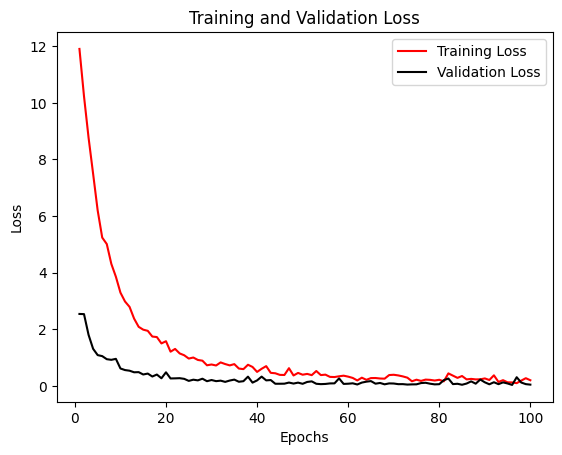

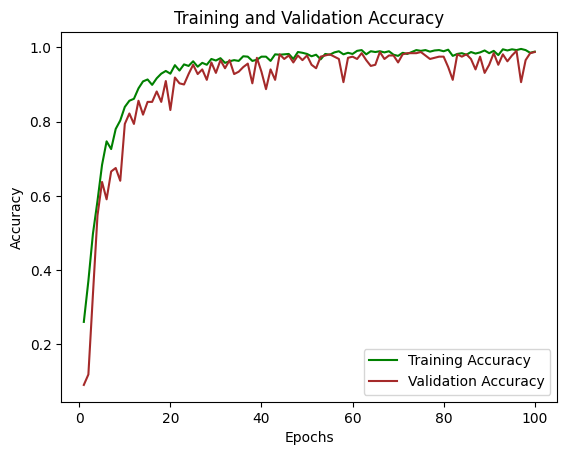

Test Loss: 2.8476, Test Accuracy: 45.00%
F1 SCORE: 0.4252


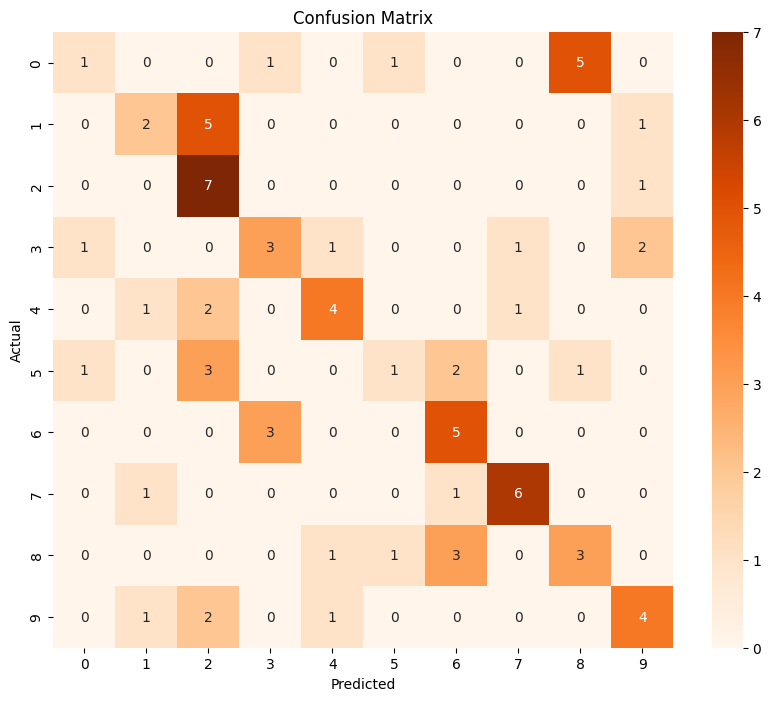

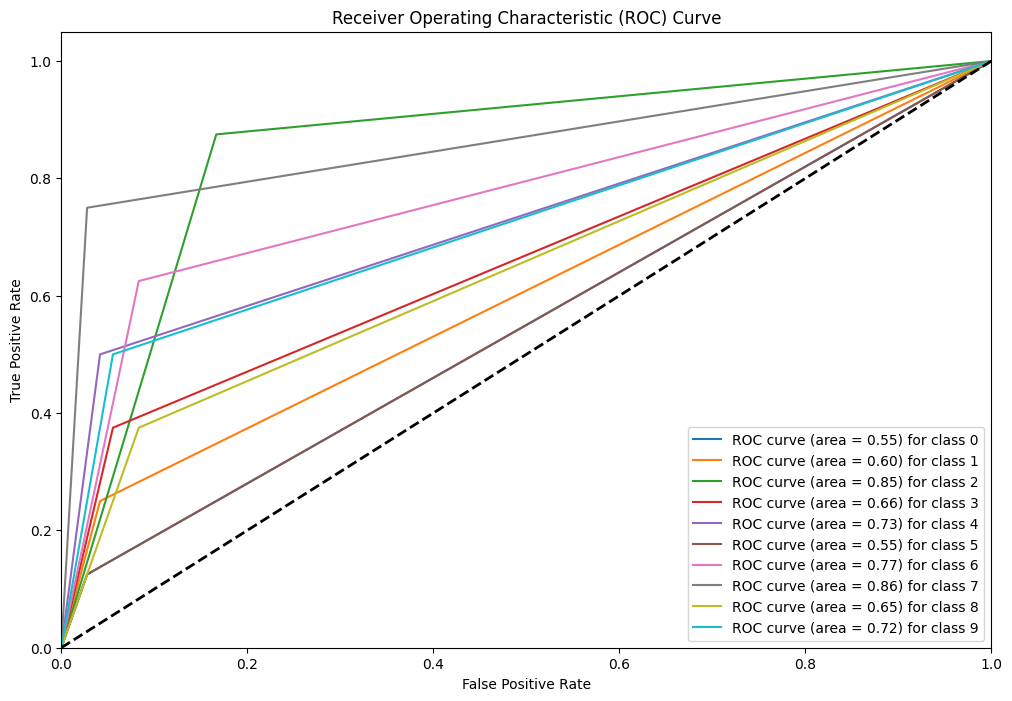

Total_parameters: 6322984
Trainable_parameters: 6322984
Non_Trainable_parameters: 0


In [ ]:
# Instantiate your model, optimizer, and loss function
print('Articture_2')
print('tranformer_4_head')
epochs = 100
tranformer_4_head = CnnTransformerModel(input_channels = 9 , output_channels = 20,d_model= 880, num_heads=4, num_layers=2, num_classes=10,dropout=0.2)
trainer = ModelTrainer(model=tranformer_4_head,
                     optimizer=torch.optim.Adam(tranformer_4_head.parameters(), lr=0.001),
                     loss_function=nn.CrossEntropyLoss(),
                     epochs = epochs,
                     batch_size= 40,
                     model_name = 'tranformer_4_head')

# Train the model using k-fold cross-validation with batch training
train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = trainer.train(custom_data_module)
# Plot loss
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_loss_list, validation_loss_list],
                     labels = ['Training Loss', 'Validation Loss'], ylabel = 'Loss',
                     title = 'Training and Validation Loss', colors=['red', 'black'])
# Plot accuracy
trainer.plot_loss_accuracy(epochs = epochs, metric_values_list = [train_accuracy_list, validation_accuracy_list],
                     labels = ['Training Accuracy', 'Validation Accuracy'], ylabel = 'Accuracy',
                     title = 'Training and Validation Accuracy', colors=['green', 'brown'])
# # Evaluate and plot confusion matrix
trainer.evaluation_and_metrics(custom_data_module)
Total_parameters = sum(p.numel() for p in tranformer_4_head.parameters())
Trainable_parameters = sum(p.numel() for p in tranformer_4_head.parameters() if p.requires_grad)
Non_Trainable_parameters = Total_parameters - Trainable_parameters
print('Total_parameters:',Total_parameters )
print('Trainable_parameters:',Trainable_parameters)
print('Non_Trainable_parameters:',Non_Trainable_parameters )